In [1]:
import os
import shutil
import sys

import numpy as np
from scipy import sparse

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sn
sn.set()

import pandas as pd

import tensorflow as tf
from tensorflow.contrib.layers import apply_regularization, l2_regularizer

import bottleneck as bn
import utils,models,time,sys
import heapq
import math
import multiprocessing

from vaecf import MultiVAE

/usr/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
def data_generation(train_raw_data, train_dir, song_user_limit=20, user_song_limit=20, dataset_prefix='msd'):
    
    user_song_cnt = train_raw_data.groupby(['user'])['count'].count()\
                                            .reset_index(name='song_cnt')\
                                            .sort_values(['song_cnt'], ascending=False)
    
    selected_user = user_song_cnt[user_song_cnt.song_cnt>user_song_limit]
    
    selected_user['userid'] = range(len(selected_user))
    
    filter_1 = pd.merge(train_raw_data, selected_user, on='user') 
    
    song_user_cnt = train_raw_data.groupby(['song'])['count'].count()\
                                            .reset_index(name='user_cnt')\
                                            .sort_values(['user_cnt'], ascending=False)
    selected_song = song_user_cnt[song_user_cnt.user_cnt>song_user_limit]
    
    selected_song['songid'] = range(len(selected_song))
    
    
    top_record = pd.merge(filter_1, selected_song, on='song')
    result = top_record.sort_values(by='userid')
    result['rate'] = 1
    result['timestamp'] = 0
    msk = np.random.rand(len(result)) < 0.7
    train = result[msk]
    test = result[~msk]
    train.to_csv(train_dir+dataset_prefix+'.train.rating',columns=['userid','songid','rate','timestamp'], index=False, sep='\t', header=False)
    test.to_csv(train_dir+dataset_prefix+'.test.rating',columns=['userid','songid','rate','timestamp'], index=False, sep='\t', header=False)
    test_neg_file = train_dir+dataset_prefix+'.test.negative'
    negative_candidate = selected_song[selected_song.songid.isin(result.songid.unique())]
    with open(test_neg_file,'w') as f:
        for index, row in test.iterrows():
            userid = row['userid']
            songid = row['songid']
            user_history = result[result.userid==userid]
            negative = negative_candidate[~negative_candidate.songid.isin(user_history.songid)].sample(99).songid
            f.write('('+str(userid)+','+str(songid)+')'+'\t'+'\t'.join([str(item) for item in negative])+'\n')


In [3]:
train_dir = "../train/"
test_dir = "../test/"
train_triplets_file=train_dir+"kaggle_visible_evaluation_triplets.txt"
valid_triplets_file=test_dir+"year1_valid_triplets_hidden.txt"
test_triplets_file=test_dir+"year1_test_triplets_hidden.txt"
user_file = train_dir+'kaggle_users.txt'
song_file = train_dir+'kaggle_songs.txt'

user2id = pd.read_table(user_file,names=['user'],header=None)
user2id['userid'] = user2id.index
song2id = pd.read_table(song_file,names=['song','songid'],sep=' ',header=None)
train_raw_data = pd.read_table(train_triplets_file, names=['user','song','count'],header=None)
test_raw_data = pd.read_table(valid_triplets_file, names=['user','song','count'], header=None)

In [4]:
data_generation(train_raw_data, train_dir, 100, 20, dataset_prefix='msd-little')

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [5]:
def load_train_data(csv_file):
    tp = pd.read_table(csv_file,header=None,names=['uid','sid','rate','timestamp'])
    n_users = tp['uid'].max() + 1
    n_items = tp['sid'].max() + 1

    rows, cols = tp['uid'], tp['sid']
    data = sparse.csr_matrix((np.ones_like(rows),
                             (rows, cols)), dtype='float64',
                             shape=(n_users, n_items))
    return n_users, n_items, data

def load_test_data(csv_file):
    tp_tr = pd.read_table(csv_file,header=None,names=['uid','sid','rate','timestamp'])

    start_idx = tp_tr['uid'].min()
    end_idx = tp_tr['uid'].max()

    rows_tr, cols_tr = tp_tr['uid'] - start_idx, tp_tr['sid']

    data_tr = sparse.csr_matrix((np.ones_like(rows_tr),
                             (rows_tr, cols_tr)), dtype='float64', shape=(end_idx - start_idx + 1, n_items))

    return data_tr

def load_rating_file_as_list(filename):
    ratingList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            user, item = int(arr[0]), int(arr[1])
            ratingList.append([user, item])
            line = f.readline()
    return ratingList
    
def load_negative_file(filename):
    negativeList = []
    with open(filename, "r") as f:
        line = f.readline()
        while line != None and line != "":
            arr = line.split("\t")
            negatives = []
            for x in arr[1: ]:
                negatives.append(int(x))
            negativeList.append(negatives)
            line = f.readline()
    return negativeList


In [6]:
class evaluation(object):
    def __init__(self, testRatings, testNegatives, K):
        self.testRatings = testRatings
        self.testNegatives = testNegatives
        self.K = K

    def getHitRatio(self, ranklist, gtItem):
        for item in ranklist:
            if item == gtItem:
                return 1
        return 0

    def getNDCG(self, ranklist, gtItem):
        for i in xrange(len(ranklist)):
            item = ranklist[i]
            if item == gtItem:
                return math.log(2) / math.log(i+2)
        return 0

    def eval_one_rating(self, idx):
        return (0.0, 0.0)
    
    def evaluate(self, num_thread, limit_size=0):
        _rec = {}
        if limit_size==0:
            testidx = xrange(len(self.testRatings))
        else:
            testidx = xrange(min(len(self.testRatings),limit_size))
        hits, ndcgs = [],[]
        st = time.time()
        if(num_thread > 1): # Multi-thread
            pool = multiprocessing.Pool(processes=num_thread)
            res = pool.map(self.eval_one_rating, testidx)
            pool.close()
            pool.join()
            hits = [r[0] for r in res]
            ndcgs = [r[1] for r in res]
            return (hits, ndcgs)
        # Single thread
        for idx in testidx:
            (hr,ndcg) = self.eval_one_rating(idx)
            hits.append(hr)
            ndcgs.append(ndcg)  
        return (hits, ndcgs)
    
class vaecf_evaluation(evaluation):
    def __init__(self, pred, testRatings, testNegatives, K):
        super(vaecf_evaluation, self).__init__(testRatings, testNegatives, K)
        self.pred = pred
        
    def eval_one_rating(self,idx):
        rating = self.testRatings[idx]
        items = self.testNegatives[idx]
        u = rating[0]
        gtItem = rating[1]
        items.append(gtItem)
        # Get prediction scores
        map_item_score = {}
        origin_result = self.pred[u]
        for i in xrange(len(items)):
            item = items[i]
            # map_item_score[item] = np.random.random()
            map_item_score[item] = origin_result[item]
        items.pop()
        # print map_item_score

        # Evaluate top rank list
        ranklist = heapq.nlargest(self.K, map_item_score, key=map_item_score.get)
        hr = self.getHitRatio(ranklist, gtItem)
        ndcg = self.getNDCG(ranklist, gtItem)
        return (hr, ndcg)

class itemcf_evaluation(evaluation):
    
    def __init__(self, model, testRatings, testNegatives, K):
        super(itemcf_evaluation, self).__init__(testRatings, testNegatives, K)
        self.model = model
    
    def eval_one_rating(self, idx):
        rating = self.testRatings[idx]
        items = self.testNegatives[idx]
        u = rating[0]
        gtItem = rating[1]
        items.append(gtItem)
        # Get prediction scores
        map_item_score = {}
        if u in u2s:
            origin_result = self.model.knn_score(u2s[u], items)
        else:
            origin_result = {}
        for i in xrange(len(items)):
            item = items[i]
            if item in origin_result:
                map_item_score[item] = origin_result[item]
            else:
                map_item_score[item] = 0.0
        items.pop()

        # Evaluate top rank list
        ranklist = heapq.nlargest(self.K, map_item_score, key=map_item_score.get)
        hr = self.getHitRatio(ranklist, gtItem)
        ndcg = self.getNDCG(ranklist, gtItem)
        return (hr, ndcg)

In [7]:
dataset_name='msd-little'
train_dir = "../train/"
print 'reading training and testing file.'

n_users, n_items, train_data = load_train_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
vad_data_tr = load_test_data(os.path.join(train_dir, '%s.train.rating' % dataset_name))
vad_data_te = load_test_data(os.path.join(train_dir, '%s.test.rating' % dataset_name))
testRatings =  load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = load_negative_file("../train/%s.test.negative" % dataset_name)

N = min(train_data.shape[0],vad_data_te.shape[0])
idxlist = range(N)

# training batch size
batch_size = 500
batches_per_epoch = int(np.ceil(float(N) / batch_size))

N_vad = min(vad_data_tr.shape[0],vad_data_te.shape[0])
idxlist_vad = range(N_vad)

# validation batch size (since the entire validation set might not fit into GPU memory)
batch_size_vad = 200

# the total number of gradient updates for annealing
total_anneal_steps = 200000
# largest annealing parameter
anneal_cap = 0.2

# p_dims = [200, 600, n_items]
p_dims = [500, n_items]

tf.reset_default_graph()
vae = MultiVAE(p_dims, lam=0.000, lr=1e-3, random_seed=98765)

saver, logits_var, loss_var, train_op_var, merged_var = vae.build_graph()

ndcg_var = tf.Variable(0.0)
ndcg_dist_var = tf.placeholder(dtype=tf.float64, shape=None)
ndcg_summary = tf.summary.scalar('ndcg_at_k_validation', ndcg_var)
ndcg_dist_summary = tf.summary.histogram('ndcg_at_k_hist_validation', ndcg_dist_var)
merged_valid = tf.summary.merge([ndcg_summary, ndcg_dist_summary])

pro_dir = train_dir
arch_str = "I-%s-I" % ('-'.join([str(d) for d in vae.dims[1:-1]]))
log_dir = pro_dir+'/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

print("log directory: %s" % log_dir)
summary_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())

chkpt_dir = pro_dir+'/VAE_anneal{}K_cap{:1.1E}/{}'.format(
    total_anneal_steps/1000, anneal_cap, arch_str)

if not os.path.isdir(chkpt_dir):
    os.makedirs(chkpt_dir) 
    
print("chkpt directory: %s" % chkpt_dir)

reading training and testing file.
INFO:tensorflow:Scale of 0 disables regularizer.
log directory: ../train//VAE_anneal200K_cap2.0E-01/I-500-I
chkpt directory: ../train//VAE_anneal200K_cap2.0E-01/I-500-I


In [8]:
n_epochs = 30
ndcgs_vad = []
hrs_vad = []
best_ndcg = 0
pred_result = []

with tf.Session() as sess:

    init = tf.global_variables_initializer()
    sess.run(init)

    best_ndcg = -np.inf

    update_count = 0.0
    
    for epoch in range(n_epochs):
        np.random.shuffle(idxlist)
        # train for one epoch
        for bnum, st_idx in enumerate(range(0, N, batch_size)):
            end_idx = min(st_idx + batch_size, N)
            X = train_data[idxlist[st_idx:end_idx]]
            
            if sparse.isspmatrix(X):
                X = X.toarray()
            X = X.astype('float32')           
            
            if total_anneal_steps > 0:
                anneal = min(anneal_cap, 1. * update_count / total_anneal_steps)
            else:
                anneal = anneal_cap
            
            feed_dict = {vae.input_ph: X, 
                         vae.keep_prob_ph: 0.5, 
                         vae.anneal_ph: anneal,
                         vae.is_training_ph: 1}        
            sess.run(train_op_var, feed_dict=feed_dict)

            if bnum % 100 == 0:
                summary_train = sess.run(merged_var, feed_dict=feed_dict)
                summary_writer.add_summary(summary_train, 
                                           global_step=epoch * batches_per_epoch + bnum) 
            
            update_count += 1
        
        X = vad_data_tr
        
        if sparse.isspmatrix(X):
            X = X.toarray()
        X = X.astype('float32')

        pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
        pred_val[X.nonzero()] = -np.inf
        topk=10
        limit=10000
        evaluation = vaecf_evaluation(pred_val, testRatings, testNegatives, topk)
        (hits, ndcgs) = evaluation.evaluate(1, limit_size=limit)
        hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
        print('epoch = %d, test_size = %d, HR = %.4f, NDCG = %.4f'  % (epoch, len(hits), hr, ndcg))
        
        ndcgs_vad.append(ndcg)
        hrs_vad.append(hr)

        # update the best model (if necessary)
        if ndcg > best_ndcg:
            saver.save(sess, '{}/model'.format(chkpt_dir))
            best_ndcg = ndcg
            

epoch = 0, test_size = 10000, HR = 0.3395, NDCG = 0.1910
epoch = 1, test_size = 10000, HR = 0.3523, NDCG = 0.1969
epoch = 2, test_size = 10000, HR = 0.3531, NDCG = 0.1972
epoch = 3, test_size = 10000, HR = 0.3543, NDCG = 0.2017
epoch = 4, test_size = 10000, HR = 0.3603, NDCG = 0.2059
epoch = 5, test_size = 10000, HR = 0.3696, NDCG = 0.2132
epoch = 6, test_size = 10000, HR = 0.3830, NDCG = 0.2241
epoch = 7, test_size = 10000, HR = 0.4015, NDCG = 0.2382
epoch = 8, test_size = 10000, HR = 0.4254, NDCG = 0.2563
epoch = 9, test_size = 10000, HR = 0.4476, NDCG = 0.2724
epoch = 10, test_size = 10000, HR = 0.4679, NDCG = 0.2863
epoch = 11, test_size = 10000, HR = 0.4864, NDCG = 0.2993
epoch = 12, test_size = 10000, HR = 0.4999, NDCG = 0.3081
epoch = 13, test_size = 10000, HR = 0.5131, NDCG = 0.3168
epoch = 14, test_size = 10000, HR = 0.5208, NDCG = 0.3229
epoch = 15, test_size = 10000, HR = 0.5256, NDCG = 0.3270
epoch = 16, test_size = 10000, HR = 0.5303, NDCG = 0.3299
epoch = 17, test_size = 

In [9]:
# ItemCF  
train_file = '../train/%s.train.rating' % dataset_name
u2s = dict()
s2u = dict()
print 'reading training file.'
with open(train_file, 'r') as f:
    for line in f:
        if line != None and line != "":
            arr = line.split("\t")
            user, song = int(arr[0]), int(arr[1])
            if user not in u2s:
                u2s[user] = set()
            u2s[user].add(song)
            if song not in s2u:
                s2u[song] = set()
            s2u[song].add(user)

testRatings =  load_rating_file_as_list("../train/%s.test.rating" % dataset_name)
testNegatives = load_negative_file("../train/%s.test.negative" % dataset_name)
            
print 'constructing model.'
knn = 1000
model = models.ItemCF(u2s, s2u, sim_method='cos', alpha=0.5, Q=1, knn=knn)
limit = 10000
print 'evaluating, test size:',len(testRatings),', limit:', limit
itemcf_eval = itemcf_evaluation(model, testRatings, testNegatives, K=10)
(hits, ndcgs) = itemcf_eval.evaluate(num_thread=1, limit_size=limit)
itemcf_hr, itemcf_ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('ItemCF, HR = %.4f, NDCG = %.4f'  % (itemcf_hr, itemcf_ndcg))

reading training file.
constructing model.
Constructing ItemCF_cos
	Ranking Pop Items. tot: 1758
	Calc Item Similarity:cos,alpha=0.5,Q=1
evaluating, test size: 44967 , limit: 10000
ItemCF, HR = 0.5251, NDCG = 0.3357


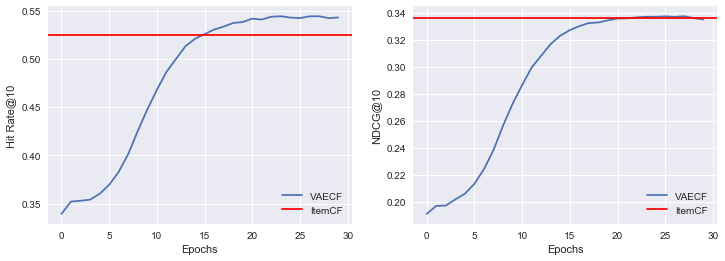

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(hrs_vad)
ax1.set_ylabel("Hit Rate@%d" % topk)
ax1.set_xlabel("Epochs")
ax1.axhline(y=itemcf_hr, color='r', linestyle='-')
ax1.legend(['VAECF','ItemCF'])

ax2.plot(ndcgs_vad)
ax2.set_ylabel("NDCG@%d" % topk)
ax2.set_xlabel("Epochs")
ax2.axhline(y=itemcf_ndcg, color='r', linestyle='-')
ax2.legend(['VAECF','ItemCF'])
pass

In [ ]:
# Case sdudy
X = vad_data_tr
if sparse.isspmatrix(X):
    X = X.toarray()
X = X.astype('float32')
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(chkpt_dir+'/model.meta')
    saver.restore(sess, tf.train.latest_checkpoint(chkpt_dir))
    pred_val = sess.run(logits_var, feed_dict={vae.input_ph: X} )
    pred_val[X.nonzero()] = -np.inf
    limit=500
    evaluation = vaecf_evaluation(pred_val, testRatings, testNegatives, topk)
    (hits, ndcgs) = evaluation.evaluate(1, limit_size=limit)
    hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
    print hr, ndcg